# Finale Aufgabe für Praktikum Deep Learning <br>Textgenerierung mit RNN: Modelltraining

* **Name:** Fabian Schotte
* **Email:** fabian.schotte@rwu.de
* **Matrikelnummer:** 35604
* **Studiengang:** Angewandte Informatik

In [57]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pylab as plt
from work import models
import time 

os.makedirs("models", exist_ok=True)

## Vorbereitung


### Laden der Trainingsdaten
Hier werden die Trainings- und Testdaten der Kaggle Sentiment Analyis aus deren CSV-Dateien ausgelesen und die Inhalte der Spalte `text` zu dem String `kaggle_text` zusammengefasst.

In [58]:
df_train = pd.read_csv('work/kaggle_sentiment/tweet_sentiment_train.csv', encoding='utf-8', encoding_errors='replace')
df_test = pd.read_csv('work/kaggle_sentiment/tweet_sentiment_test.csv', encoding='utf-8', encoding_errors='replace')

kaggle_text_train = df_train['text'].str.cat(sep='\n')
kaggle_text_test = df_test['text'].str.cat(sep='\n')
# kaggle_text = kaggle_text_train + '\n' + kaggle_text_test
kaggle_text = kaggle_text_train
# kaggle_text = kaggle_text_test

print(kaggle_text[:500])

 I`d have responded, if I were going
 Sooo SAD I will miss you here in San Diego!!!
my boss is bullying me...
 what interview! leave me alone
 Sons of ****, why couldn`t they put them on the releases we already bought
http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth
2am feedings for the baby are fun when he is all smiles and coos
Soooo high
 Both of you
 Journey!? Wow... u just became cooler.  hehe... (is that possible!?)
 as much as i love to be hopef


Im nächsten Codeblock wird ein Set der einzigartigen Charaktere im String `kaggle_text` mit dem Namen `vocab` erstellt. Ebenso werden die darin vorhandenen Charaktere ausgegeben und die Länge des Sets ausgegeben.

In [59]:
vocab = sorted(set(kaggle_text))
print(vocab)
print(f"vocab size = {len(vocab)}")

['\t', '\n', ' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\xa0', '´', '½', '¿', 'Â', 'ï']
vocab size = 102


## Preprocessing
Im folgenden Codeblock wird ein Beispieltext zu einer Liste von Charakteren aufgeteilt und ausgegeben. Diese List wird als `chars` gespeichert.

In [60]:
example_texts = ['hello world', 'hello world']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'h', b'e', b'l', b'l', b'o', b' ', b'w', b'o', b'r', b'l', b'd'],
 [b'h', b'e', b'l', b'l', b'o', b' ', b'w', b'o', b'r', b'l', b'd']]>

In der Funktion `ids_from_chars` werden die gegebenen Charaktere in eine zugeordnete Zahl für das Training und die Vorhersage umgewandelt.
Die Funktion `chars_from_ids` funktioniert genau umgekehrt, indem hier die gegebenen Zahlen in die dazugehörigen Charaktere umgewandelt werden.
Hier werden auch die beiden Methoden für den Beispieltext aus `chars` durchgeführt und ausgegeben. Zur Vollständigkeit werden die Charaktere, die aus den Zahlenwerten generiert wurden, wieder zu einem String zusammengefügt.

In [61]:
ids_from_chars = keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
ids = ids_from_chars(chars)
print(ids)

chars_from_ids = keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)
chars = chars_from_ids(ids)
print(chars)

tf.strings.reduce_join(chars, axis=-1).numpy()

<tf.RaggedTensor [[74, 71, 78, 78, 81, 3, 89, 81, 84, 78, 70],
 [74, 71, 78, 78, 81, 3, 89, 81, 84, 78, 70]]>
<tf.RaggedTensor [[b'h', b'e', b'l', b'l', b'o', b' ', b'w', b'o', b'r', b'l', b'd'],
 [b'h', b'e', b'l', b'l', b'o', b' ', b'w', b'o', b'r', b'l', b'd']]>


array([b'hello world', b'hello world'], dtype=object)

In `text_from_ids(ids)` wird genau die Operation für das Zusammenfügen der Charaktere zu einem String ausgeführt.

In [62]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Hier wird die zuvor genannte Funktion zur Berechnung der Zahlenwerte aus den Charakteren `kaggle_text` verwendet, um die Trainingsdaten als Zahlenwerte zu erhalten. Diese werden in `all_ids` gespeichert.

In [63]:
all_ids = ids_from_chars(tf.strings.unicode_split(kaggle_text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1905188,), dtype=int64, numpy=array([ 3, 43, 66, ..., 85, 11, 11])>

Als nächstes wird ein Dataset aus den Zahlenwerten generiert. Die ersten 10 Werte des Datasets werden als Charaktere ausgegeben.

In [64]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

 
I
`
d
 
h
a
v
e
 


Mit `seq_lenth` wird die Länge der Sequenz definiert, mit dem die Modelle trainiert werden.

In [65]:
seq_length = 100

Im nächsten Schritt werden die Sequenzen mit Hilfe von `seq_lenth` generiert. Die Daten für die Sequenzeb kommen aus dem zuvor angelegten Dataset `ids_dataset`.
Dazu werden auch die Charaktere der ersten Sequenz zuerst einzeln und dann als Text ausgegeben.

In [66]:
sequences = ids_dataset.batch(seq_length + 1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq).numpy())
for seq in sequences.take(1):
  print(text_from_ids(seq).numpy())

[b' ' b'I' b'`' b'd' b' ' b'h' b'a' b'v' b'e' b' ' b'r' b'e' b's' b'p'
 b'o' b'n' b'd' b'e' b'd' b',' b' ' b'i' b'f' b' ' b'I' b' ' b'w' b'e'
 b'r' b'e' b' ' b'g' b'o' b'i' b'n' b'g' b'\n' b' ' b'S' b'o' b'o' b'o'
 b' ' b'S' b'A' b'D' b' ' b'I' b' ' b'w' b'i' b'l' b'l' b' ' b'm' b'i'
 b's' b's' b' ' b'y' b'o' b'u' b' ' b'h' b'e' b'r' b'e' b' ' b'i' b'n'
 b' ' b'S' b'a' b'n' b' ' b'D' b'i' b'e' b'g' b'o' b'!' b'!' b'!' b'\n'
 b'm' b'y' b' ' b'b' b'o' b's' b's' b' ' b'i' b's' b' ' b'b' b'u' b'l'
 b'l' b'y' b'i']
b' I`d have responded, if I were going\n Sooo SAD I will miss you here in San Diego!!!\nmy boss is bullyi'


In `split_input_target(sequence)` werden die Inputs und Target Labels der Sequenz generiert

In [67]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

Im folgenden Code wird die zuvor erstellte Methode `split_input_target` auf die Sequenzen der Kaggle Trainingsdaten angewendet und die Länge des Datasets ausgegeben

In [68]:
kaggle_dataset = sequences.map(split_input_target)
len(kaggle_dataset)

18863

Als nächstes werden Beispiele für die Input und Labels als Text und mit dessen Shape ausgegeben.

In [69]:
for input_example, target_example in kaggle_dataset.take(1):
    print("Input:", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())
    print("Input shape:", input_example.shape)
    print("Target shape:", target_example.shape)

Input: b' I`d have responded, if I were going\n Sooo SAD I will miss you here in San Diego!!!\nmy boss is bully'
Target: b'I`d have responded, if I were going\n Sooo SAD I will miss you here in San Diego!!!\nmy boss is bullyi'
Input shape: (100,)
Target shape: (100,)


Als nächstes werden folgende Variablen für das Training definiert:
- Mit `BATCH_SIZE` wird definiert, wie viele Input-Label-Paare in einer Epoche verarbeitet werden. Hier sind dies 150
- Mit `BUFFER_SIZE` wird die Anzahl der Elemente des Datasets definiert, die zufällig gemischt werden, bevor sie in die Batches eingeteilt werden.

Dieses Variablen werden hier auch auf das Dataset `kaggle_dataset` angewendet und dieses Dataset wird ebenfalls ausgegeben. 

In [70]:
BATCH_SIZE = 150
BUFFER_SIZE = 1000

kaggle_dataset = (
    kaggle_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
)
kaggle_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(150, 100), dtype=tf.int64, name=None), TensorSpec(shape=(150, 100), dtype=tf.int64, name=None))>

### 1. GRU-Modell

Hier werden die Variablen für das erste GRU-Modell definiert.
`vocab_size_1` wird auf die Anzahl der einzigartigen Zeichen gesetzt und der Vektor für die Embedding-Schicht wird in `embedding_dim_1` auf 256 gesetzt. Die Anzahl der Neuronen wird in `rnn_units` auf 2048 gesetzt.

In [71]:
vocab_size_1 = len(ids_from_chars.get_vocabulary())
embedding_dim_1 = 256
rnn_units_1 = 2048

Hier wird das erste GRU-Modell definiert. Als erstes wird ein Input Layer durchlaufen, worauf ein Embedding Layer folgt. Im Anschluss wird ein Stacked GRU-Layer verwendet, dass heißt es werden zwei GRU-Layers hintereinander verwendet. Dieses kann durch diesen Aufbau bessere Modelle trainineren, z.B. ein besseres Verständnis von Grammatikregeln.
Danach wird ein Dense Layer für den Output verwendet.

In [72]:
inputs_1 = keras.layers.Input(shape=(None,), dtype='int32', name='input_tokens')
embedding_1 = keras.layers.Embedding(input_dim=vocab_size_1, output_dim=embedding_dim_1)(inputs_1)
gru_1, gru_state_1 = keras.layers.GRU(units=rnn_units_1, return_sequences=True, return_state=True)(embedding_1)
gru_1, gru_state_1 = keras.layers.GRU(units=rnn_units_1, return_sequences=True, return_state=True)(gru_1)
outputs_1 = keras.layers.Dense(units=vocab_size_1, activation='softmax')(gru_1)

gru_model_1 =  keras.Model(inputs=inputs_1, outputs=outputs_1)

#### Testen des Modells

Hier werden zum Test die Dimension des ersten Batches as dem Dataset ausgegeben. Die Ausgabe gibt die Batch Size, Sequence Length und die Vocab Size des ersten GRU-Modells an.

In [73]:
for input_example_batch_1, target_example_batch_1 in kaggle_dataset.take(1):
    example_batch_predictions_model_1 = gru_model_1(input_example_batch_1)
    print(example_batch_predictions_model_1.shape, "# (batch_size, sequence_length, vocab_size_1)")

(150, 100, 103) # (batch_size, sequence_length, vocab_size_1)


Hier wird die Zusammenfassung der wichtigsten Informationen des ersten GRU-Modells angezeigt.

In [74]:
gru_model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_tokens (InputLayer)       │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 256)      │        26,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ [(None, None, 2048),   │    14,168,064 │
│                                 │ (None, 2048)]          │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ [(None, None, 2048),   │    25,178,112 │
│                                 │ (None, 2048)]          │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 103)      │       211,047 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,583,591 (151.00 MB)

 Trainable params: 39,583,591 (151.00 MB)

 Non-trainable params: 0 (0.00 B)

Im nächsten Codeblock wird die Zufallsauswahl der Zahlenwerte durch das erste GRU-Modell getestet. Die finale Ausgabe ist das Array mit den Zufallswerten, in dem unnötige Dimensionen entfernt wurden.

In [75]:
sampled_indices_gru_model_1 = tf.random.categorical(example_batch_predictions_model_1[0], num_samples=1)
sampled_indices_gru_model_1 = tf.squeeze(sampled_indices_gru_model_1, axis=-1).numpy()
sampled_indices_gru_model_1

array([ 29,  63,  31,  70,  89,  40,  97,  63,  51,  20,  64,  89,   7,
        22,  38,  24,  19,  31,  76,   8,  52,  46,  67,  48,  53,   5,
        16,  42,  57,  57,  60, 102,  11,  56,  53,  10,  21,  36,  20,
        82,   7,  51,  63,  10,  10,  99,  37,  41,  62,  99,  82,  61,
        38,  76,  97,  25,  82,   4,  90,  82,  33,  86,  28,   7,  23,
        14,  93,  26,  36,  81,  66,  60,  14,  42,   6,  35,  82,  61,
        39,  41,  44,  32,  20,   0,   3,  70,  51,   8,  73,  80,   4,
         1,  75,  10,  59,  50,  54,   4,  53,  68])

In dem folgenden Code werden die Zahlenwerte des ersten Batches genommen und als Text ausgegeben.
Es wird ebenfalls der Text ausgegeben, der durch die Predictions aus dem GRU-Modell 1 erzeugt wurden.

In [76]:
print("Input:\n", text_from_ids(input_example_batch_1[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices_gru_model_1).numpy())

Input:
 b'   you`re going to chiodos tonight, right? just kill something for me.\n While im stuck INSIDE in Elk'

Next Char Predictions:
 b';]=dwF\xc2\xa0]Q2^w%4D61=j&RLaNS#.HWWZ\xc3\xaf)VS(3B2p%Q]((\xc2\xbdCG\\\xc2\xbdp[Dj\xc2\xa07p!xp?t:%5,{8Bo`Z,H$Ap[EGJ>2[UNK] dQ&gn!\ti(YPT!Sb'


### Training

#### Loss

Hier wird die Verlustfunktion definiert. In diesem Fall handelt es sich um Sparse Categorial Crossentropy mit dem Parameter `from_logits` als `True`.

In [77]:
loss_1 = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

Hier wird jetzt der Loss auf das GRU-Modell angewendet, indem die Variablen `target_example_batch_1` und `example_batch_predictions_1` als Parameter verwendet werden. Die Ausgabe ist hierzu einmal die Dimensionen des Prediction Modells 1 sowie die Ausgabe des Mean Loss des ersten Modells.

In [78]:
example_batch_mean_loss_model_1 = loss_1(target_example_batch_1, example_batch_predictions_model_1)
print("Prediction shape: ", example_batch_predictions_model_1.shape, " # (batch_size, sequence_length, vocab_size_1)")
print("Mean loss:        ", example_batch_mean_loss_model_1)

Prediction shape:  (150, 100, 103)  # (batch_size, sequence_length, vocab_size_1)
Mean loss:         tf.Tensor(4.6353674, shape=(), dtype=float32)


/opt/conda/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Als nächstes wird der Exponentialwert des Mean Loss berechnet. Dieser Sollte in etwa ähnlich zur Vocab Size sein.

In [79]:
tf.exp(example_batch_mean_loss_model_1).numpy()

np.float32(103.06577)

#### Optimizer

Als nächstes wird das Model kompiliert. Dabei wird der Optimizer `adam`, als Metrik die Accuracy verwendet. Damit es im Ablauf des Trainings keine Fehler gibt, wird der Parameter `run_eagerly` mit dem Wert `True` verwendet.

In [80]:
gru_model_1.compile(optimizer='adam', loss=loss_1, metrics=['accuracy'], run_eagerly=True)

#### Early Stopping

Hier wird die Early Stopping Callback Funktion für das erste GRU-Modell definiert, damit das Training gestoppt wird, sobald das Modell einen optimalen Wert erreicht hat. Hier wird das Training gestoppt, sobald das Modell sich nicht innerhalb von 2 Epochen um 0,002 verbessert hat.

In [81]:
early_stopping_gru_model_1 = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.002, patience=2)

#### Konfiguration von Checkpoints

Als nächstes wird die Checkpoints Callback definiert, damit nach jeder Epoche die Gew ichtung des Modells gespeichert wird.

In [82]:
checkpoint_dir = './work/training_checkpoints/gru_model_1'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

checkpoint_callback_gru_model_1=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

#### Ausführen des Trainings

Für das Training wird eine EPOCHS Konstante definiert, hier ist dies 30 Epochen, dass heißt, dass das Modell 30 mal komplett durchlaufen wird.

In [83]:
EPOCHS_1 = 30

Hier wird das erste Modell trainiert. In dem Modell werden das vorher definierte Dataset, die Epochenzahl sowie die Callback Funktionen verwendet. Weiterhin wird für einen späteren Vergleich der Modelle eine Zeitstoppung der gesamten Trainingszeit durchgeführt.

In [84]:
start = time.perf_counter()
gru_model_1_history = gru_model_1.fit(kaggle_dataset, epochs=EPOCHS_1, callbacks=[checkpoint_callback_gru_model_1, early_stopping_gru_model_1])
end = time.perf_counter()
gru_model_1_training_time = end - start

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 360ms/step - accuracy: 0.2011 - loss: 3.4354
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 366ms/step - accuracy: 0.4112 - loss: 2.1273
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.4996 - loss: 1.7798
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 366ms/step - accuracy: 0.5356 - loss: 1.6321
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 366ms/step - accuracy: 0.5575 - loss: 1.5406
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 364ms/step - accuracy: 0.5751 - loss: 1.4656
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 367ms/step - accuracy: 0.5934 - loss: 1.3923
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.6128 - loss: 1.3162
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 365ms/step - accuracy: 0.6352 - loss: 1.2305
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 367ms/step - accuracy: 0.6623 - loss: 1.1349
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 371ms/step - accuracy: 0.6924 - loss: 1.0300
Epoch 12/30
125/125

#### Speichern

Im letzten Schritt für das erste GRU-Modell wird dieses gespeichert, damit es im Notebook für die Textgenerierung verwendet werden kann.

In [85]:
gru_model_1.save('work/models/gru_model_1.keras')

### 2. GRU-Modell

Hier werden wie beim ersten GRU-Modell für das zweite GRU-Modell auch die Vocab Size, die Embedding Dimension sowie die Anzahl der Neuronen festgelegt, diese Anzahl beträgt hier 1024 anstatt der 2048 aus dem ersten Modell.

In [86]:
vocab_size_2 = len(ids_from_chars.get_vocabulary())
embedding_dim_2 = 256
rnn_units_2 = 1024

Hier wird das zweite GRU-Modell definiert, im Vergleich zum ersten Modell hat dieses zwischen den beiden GRU-Layers eine weitere Schicht. Dies ist das Dropout Layer, dass bewirkt, dass das Modell Overfitting vermeidet, indem 20% der Neuronen auf 0 gesetzt werden. Mit diesem Layer soll das zweite GRU-Layer bessere Ergebnisse erzeugen.

In [87]:
inputs_2 = keras.layers.Input(shape=(None,), dtype='int32', name='input_tokens')
embedding_2 = keras.layers.Embedding(input_dim=vocab_size_2, output_dim=embedding_dim_2)(inputs_2)
gru_2, gru_state_2 = keras.layers.GRU(units=rnn_units_2, return_sequences=True, return_state=True)(embedding_2)
dropout_2 = keras.layers.Dropout(0.2)(gru_2)
gru_2, gru_state_2 = keras.layers.GRU(units=rnn_units_2, return_sequences=True, return_state=True)(dropout_2)
outputs_2 = keras.layers.Dense(units=vocab_size_2, activation='softmax')(gru_2)

gru_model_2 = keras.Model(inputs=inputs_2, outputs=outputs_2)

#### Testen des Modells

Hier wird wie auch beim ersten GRU-Modell das erste Batch des Datasets abgerufen und dessen Dimensionen angezeigt.

In [88]:
for input_example_batch_2, target_example_batch_2 in kaggle_dataset.take(1):
    example_batch_predictions_gru_model_2 = gru_model_2(input_example_batch_2)
    print(example_batch_predictions_gru_model_2.shape, "# (batch_size, sequence_length, vocab_size_2)")

(150, 100, 103) # (batch_size, sequence_length, vocab_size_2)


2025-06-25 22:16:21.244485: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Der Vorgang ist hier ebenfalls der gleiche wie beim ersten Modell, indem die Zusammenfassung des zweiten GRU-Modells ausgegeben wird.

In [89]:
gru_model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_tokens (InputLayer)       │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 256)      │        26,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ [(None, None, 1024),   │     3,938,304 │
│                                 │ (None, 1024)]          │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ [(None, None, 1024),   │     6,297,600 │
│                                 │ (None, 1024)]          │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 103)      │       105,575 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,367,847 (39.55 MB)

 Trainable params: 10,367,847 (39.55 MB)

 Non-trainable params: 0 (0.00 B)

Hier wird wie im ersten GRU-Modell auch die Prediction des Modells getestet.

In [90]:
sampled_indices_gru_model_2 = tf.random.categorical(example_batch_predictions_gru_model_2[0], num_samples=1)
sampled_indices_gru_model_2 = tf.squeeze(sampled_indices_gru_model_2, axis=-1).numpy()
sampled_indices_gru_model_2

array([81, 45, 62, 95, 25, 56, 85, 45,  6, 77, 79, 48, 78, 79, 66,  1,  1,
       59, 30,  3, 98, 19, 11, 44, 66, 69, 88,  0, 94, 42,  2, 31, 94, 81,
       33, 79, 83, 76, 37, 32, 74, 49, 74, 29, 36, 24, 90, 68, 51, 79, 55,
        1, 88,  8, 10, 58, 69, 59, 17, 20,  7, 14, 47, 98, 88, 41, 53, 39,
       62, 48, 34, 21, 66, 42, 66, 17, 65, 86, 10, 13, 70, 58, 16, 33, 61,
       85, 16, 62, 50,  0, 22, 73, 46, 43, 87, 75, 98, 99, 10, 95])

Hier wird wie auch beim ersten GRU-Modell einmal der Text des ersten Batches ausgegeben und die Vorhersage der nächsten Zeichen des zweiten GRU-Modells.

In [91]:
print("Input:\n", text_from_ids(input_example_batch_2[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices_gru_model_2).numpy())

Input:
 b'keep writing.. booo whoo!\nI Miss Daddy and Mommy\nMy dog is officially depressed that my brother`s do'

Next Char Predictions:
 b'oK\\}7VsK$kmNlm`\t\tY< \xc2\xb41)J`cv[UNK]|H\n=|o?mqjC>hOh;B6xbQmU\tv&(XcY/2%,M\xc2\xb4vGSE\\N@3`H`/_t(+dX.?[s.\\P[UNK]4gLIui\xc2\xb4\xc2\xbd(}'


### Training

#### Loss

Hier wird die auch beim ersten GRU-Modell die Loss Funktion definiert mit der gleichen Konfiguration wie im ersten Modell.

In [92]:
loss_2 = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [93]:
example_batch_mean_loss_model_2 = loss_2(target_example_batch_2, example_batch_predictions_gru_model_2)
print("Prediction shape: ", example_batch_predictions_gru_model_2.shape, " # (batch_size, sequence_length, vocab_size_2)")
print("Mean loss:        ", example_batch_mean_loss_model_2)

Prediction shape:  (150, 100, 103)  # (batch_size, sequence_length, vocab_size_2)
Mean loss:         tf.Tensor(4.6351547, shape=(), dtype=float32)


In [94]:
tf.exp(example_batch_mean_loss_model_1).numpy()

np.float32(103.06577)

#### Optimizer

Hier wird das zweite GRU-Modell kompiliert und dazu werden die gleichen Parameter wie beim ersten GRU-Modell verwendet und die Loss Funktion `loss_2`.

In [95]:
gru_model_2.compile(optimizer='adam', loss=loss_2, metrics=['accuracy'], run_eagerly=True)

#### Early Stopping

Als nächstes wird die Early Stopping Callback eingerichtet, diese hat die gleiche Konfiguration wie aus dem ersten GRU-Modell.

In [96]:
early_stopping_model_2 = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.002, patience=2)

#### Konfiguration von Checkpoints

Die Checkpoint Callback hat hier die gleiche Konfiguration wie die für das erste GRU-Modell.

In [97]:
checkpoint_dir = './work/training_checkpoints/gru_model_2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

checkpoint_callback_gru_model_2=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

#### Ausführen des Trainings

Das Training des zweiten GRU-Modells wird auch mit 30 Epochen durchgeführt.

In [98]:
EPOCHS_2 = 30

Als nächstes wird das Training des zweiten GRU-Modells durchgeführt und die gesamte Trainingszeit gemessen.

In [99]:
start = time.perf_counter()
gru_model_2_history = gru_model_2.fit(kaggle_dataset, epochs=EPOCHS_2, callbacks=[checkpoint_callback_gru_model_2, early_stopping_model_2])
end = time.perf_counter()
gru_model_2_training_time = end - start

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 251ms/step - accuracy: 0.1907 - loss: 3.5305
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 248ms/step - accuracy: 0.3883 - loss: 2.2120
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 251ms/step - accuracy: 0.4794 - loss: 1.8578
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.5168 - loss: 1.7060
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.5371 - loss: 1.6231
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 248ms/step - accuracy: 0.5517 - loss: 1.5620
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 252ms/step - accuracy: 0.5633 - loss: 1.5144
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.5730 - loss: 1.4739
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 0.5818 - loss: 1.4368
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 254ms/step - accuracy: 0.5905 - loss: 1.4014
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - accuracy: 0.5990 - loss: 1.3662
Epoch 12/30
125/125

### Speichern

Das zweite GRU-Modell wird hier gespeichert.

In [100]:
gru_model_2.save('work/models/gru_model_2.keras')

## Bewertung und Vergleich der GRU-Modelle

Als nächstes soll ein LSTM-Modell auf der Struktur des besseren GRU-Modell erstellt werden. Damit diese Entscheidung getroffen werden kann, werden die beiden Modelle hier auf Loss, Accuracy, Perplexity und Trainingszeit vergleichen.

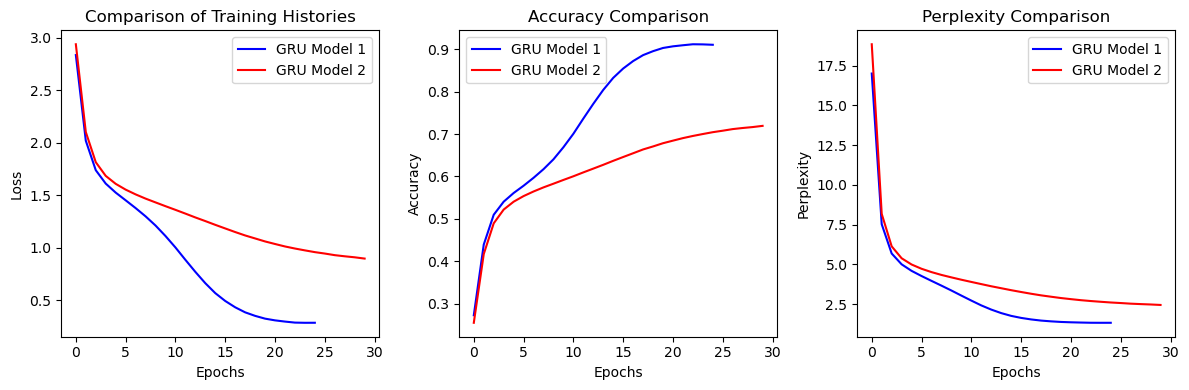

Loss:
 GRU Model 1: 0.2868843972682953
 GRU Model 2: 0.8973823189735413
Accuracy:
 GRU Model 1: 0.9104187488555908
 GRU Model 2: 0.719274640083313
Perplexity:
 GRU Model 1: 1.3322701904997185
 GRU Model 2: 2.4531730743246496
Training Times:
 GRU Model 1: 1148.437810s
 GRU Model 2: 947.854230s


In [101]:
loss1 = gru_model_1_history.history['loss']
loss2 = gru_model_2_history.history['loss']

accuracy1 = gru_model_1_history.history['accuracy']
accuracy2 = gru_model_2_history.history['accuracy']

perplexity1 = np.exp(loss1)
perplexity2 = np.exp(loss2)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4)) 

axes[0].plot(loss1, label="GRU Model 1", linestyle='-', color='blue')
axes[0].plot(loss2, label="GRU Model 2", linestyle='-', color='red')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_title("Comparison of Training Histories")
axes[0].legend()

axes[1].plot(accuracy1, label="GRU Model 1", linestyle='-', color='blue')
axes[1].plot(accuracy2, label="GRU Model 2", linestyle='-', color='red')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Comparison")
axes[1].legend()

axes[2].plot(perplexity1, label="GRU Model 1", linestyle='-', color='blue')
axes[2].plot(perplexity2, label="GRU Model 2", linestyle='-', color='red')
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Perplexity")
axes[2].set_title("Perplexity Comparison")
axes[2].legend()

plt.tight_layout()

plt.show()

print("Loss:")
print(f" GRU Model 1: {loss1[-1]}")
print(f" GRU Model 2: {loss2[-1]}")
print("Accuracy:")
print(f" GRU Model 1: {accuracy1[-1]}")
print(f" GRU Model 2: {accuracy2[-1]}")
print("Perplexity:")
print(f" GRU Model 1: {perplexity1[-1]}")
print(f" GRU Model 2: {perplexity2[-1]}")
print("Training Times:")
print(f" GRU Model 1: {gru_model_1_training_time:2f}s")
print(f" GRU Model 2: {gru_model_2_training_time:2f}s")


### LSTM-Modell

Da im ersten Durchlauf des Notebooks das erste GRU-Modell die besseren Ergebnisse erzielt hatte, wird dessen Aufbau für die Erstellung des LSTM-Modells verwendet. Dazu wird zum einen die Neuronenanzahl von 2048 verwendet.

In [102]:
vocab_size_lstm = len(ids_from_chars.get_vocabulary())
embedding_dim_lstm = 256
rnn_units_lstm = 2048

Hier wird das LSTM-Modell für den zweiten Teil der Aufgabe erstellt. Da das erste GRU-Modell besser war, wird hier wie in dem ersten GRU-Modell ein Stacked-LSTM-Modell erstellt.

In [103]:

inputs_lstm = keras.layers.Input(shape=(None,), dtype='int32', name='input_tokens')
embedding_lstm = keras.layers.Embedding(input_dim=vocab_size_lstm, output_dim=embedding_dim_lstm)(inputs_lstm)
lstm, hidden_state_1, cell_state_1 = keras.layers.LSTM(units=rnn_units_lstm, return_sequences=True, return_state=True)(embedding_lstm)
lstm, hidden_state_2, cell_state_2 = keras.layers.LSTM(units=rnn_units_lstm, return_sequences=True, return_state=True)(lstm)
outputs_lstm = keras.layers.Dense(units=vocab_size_lstm, activation='softmax')(lstm)

lstm_model = keras.Model(inputs=inputs_lstm, outputs=outputs_lstm)

#### Testen des Modells

Wie auch in den beiden GRU-Modellen, wird hier für das LSTM-Modell die Dimension der Modell Prediction ausgegeben.

In [104]:
for input_example_batch_lstm, target_example_batch_lstm in kaggle_dataset.take(1):
    example_batch_predictions_lstm_model = lstm_model(input_example_batch_lstm)
    print(example_batch_predictions_lstm_model.shape, "# (batch_size, sequence_length, vocab_size)")

(150, 100, 103) # (batch_size, sequence_length, vocab_size)


Hier wird die Zusammenfassung des LSTM-Modells ausgegeben.

In [105]:
lstm_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_tokens (InputLayer)       │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 256)      │        26,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ [(None, None, 2048),   │    18,882,560 │
│                                 │ (None, 2048), (None,   │               │
│                                 │ 2048)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ [(None, None, 2048),   │    33,562,624 │
│                                 │ (None, 2048), (None,   │               │
│                                 │ 2048)]                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 103)      │       211,047 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,682,599 (200.97 MB)

 Trainable params: 52,682,599 (200.97 MB)

 Non-trainable params: 0 (0.00 B)

Wie bei den beiden ersten Modellen wird hier für das LSTM-Modell die Prediction des Modells zum Test ausgegeben.

In [106]:
sampled_indices_lstm_model = tf.random.categorical(example_batch_predictions_lstm_model[0], num_samples=1)
sampled_indices_lstm_model = tf.squeeze(sampled_indices_lstm_model, axis=-1).numpy()
sampled_indices_lstm_model

array([ 44,   0,  38,  75,  12,  34,  64,  42,  51,  17,   0,  37,  23,
        38,   8,  21,  16,  54,  43,   8,  68,  54,  47,  70,  75,  93,
        17,   8,  12,  29,  62,  40,  39,  72,  49,   4,   6,  65,  47,
         9,  55,   8,  83,  76,  66,  59,  17,  81,  93,  77,  92,  19,
        47,  64,  94,  42,  44,  12,  15,   6,  82,   3,  70,  30,  72,
        38,  35,  60,  31,  69, 102,  39,  13,  54,  34,  12,  86,  46,
       102,  72,  32,  59,  68,  47,  64,  23,   3,  20,   8,  67,  66,
        78,  42,  53,  25,  18,   0,  63,  72,  43])

Hier gibt es den gleichen Vorgang wie bei den beiden GRU-Modellen: Zuerst wird das erste Input Sample Batch des Datasets ausgegeben, dann wird die Vorhersage der Zeichen des LSTM-Modells ausgegeben.

In [107]:
print("Input:\n", text_from_ids(input_example_batch_lstm[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices_lstm_model).numpy())

Input:
 b'king tea\n Well that\xc3\xaf\xc2\xbf\xc2\xbds disappointing to hear.\n well if i use all my tweets will be the push to make'

Next Char Predictions:
 b"J[UNK]Di*@^HQ/[UNK]C5D&3.TI&bTMdi{/&*;\\FEfO!$_M'U&qj`Y/o{kz1M^|HJ*-$p d<fDAZ=c\xc3\xafE+T@*tL\xc3\xaff>YbM^5 2&a`lHS70[UNK]]fI"


### Training

#### Loss

Als nächstes wird wie auch bei den GRU-Modellen die Loss Funktion definiert.

In [108]:
loss_lstm = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

Hier wird jetzt der Loss auf das LSTM-Modell angewendet, indem die Variablen `target_example_batch_lstm` und `example_batch_predictions_lstm_model` als Parameter verwendet werden. Die Ausgabe ist hierzu einmal die Dimensionen der Predictions des LSTM-Modell sowie die Ausgabe des Mean Loss des LSTM-Modells.

In [109]:
example_batch_mean_loss_lstm_model = loss_lstm(target_example_batch_lstm, example_batch_predictions_lstm_model)
print("Prediction shape: ", example_batch_predictions_lstm_model.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss_lstm_model)

Prediction shape:  (150, 100, 103)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.6351786, shape=(), dtype=float32)


Als nächstes wird der Exponentialwert des Mean Loss aus dem LSTM-Modell berechnet. Dieser Sollte in etwa ähnlich zur Vocab Size sein.

In [110]:
tf.exp(example_batch_mean_loss_lstm_model).numpy()

np.float32(103.04631)

#### Optimizer

Hier wird das LSTM-Modell kompiliert und dazu werden die gleichen Parameter wie beim ersten GRU-Modell verwendet und die Loss Funktion `loss_lstm`.

In [111]:
lstm_model.compile(optimizer='adam', loss=loss_lstm, metrics=['accuracy'], run_eagerly=True)

#### Konfiguration von Checkpoints

Zum Speichern der Gewichtungen des LSTM-Modells wird hier wie auch bei den GRU-Modellen eine Checkpoint Callback eingerichtet.

In [112]:
checkpoint_dir = './work/training_checkpoints/lstm_model'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

checkpoint_callback_gru_model_2=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

#### Ausführen des Trainings

Die Epochenzahl wird für das Training des LSTM-Modells ebenfalls auf 30 gesetzt.

In [113]:
EPOCHS_LSTM = 30

Das LSTM-Modell wird hier trainiert und dazu wird ebenfalls die Trainingszeit gemessen.

In [114]:
start = time.perf_counter()
lstm_model_history = lstm_model.fit(kaggle_dataset, epochs=EPOCHS_LSTM, callbacks=[checkpoint_callback_gru_model_2, early_stopping_model_2])
end = time.perf_counter()
lstm_model_training_time = end - start

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - accuracy: 0.1512 - loss: 3.8406
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - accuracy: 0.2755 - loss: 2.7227
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - accuracy: 0.3693 - loss: 2.2834
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 340ms/step - accuracy: 0.4391 - loss: 2.0166
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - accuracy: 0.4775 - loss: 1.8598
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 337ms/step - accuracy: 0.5027 - loss: 1.7582
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - accuracy: 0.5203 - loss: 1.6862
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - accuracy: 0.5333 - loss: 1.6344
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - accuracy: 0.5432 - loss: 1.5937
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 335ms/step - accuracy: 0.5526 - loss: 1.5576
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 337ms/step - accuracy: 0.5599 - loss: 1.5266
Epoch 12/30
125/125

#### Speichern

Das LSTM-Modell wird hier gespeichert.

In [115]:
lstm_model.save('work/models/lstm_model.keras')

## Vergleich aller Modelle

Zum Schluss wird der Vergleich aller drei Modelle angezeigt mit den gleichen Parametern wie auch bei dem Vergleich der beiden GRU-Modellen.

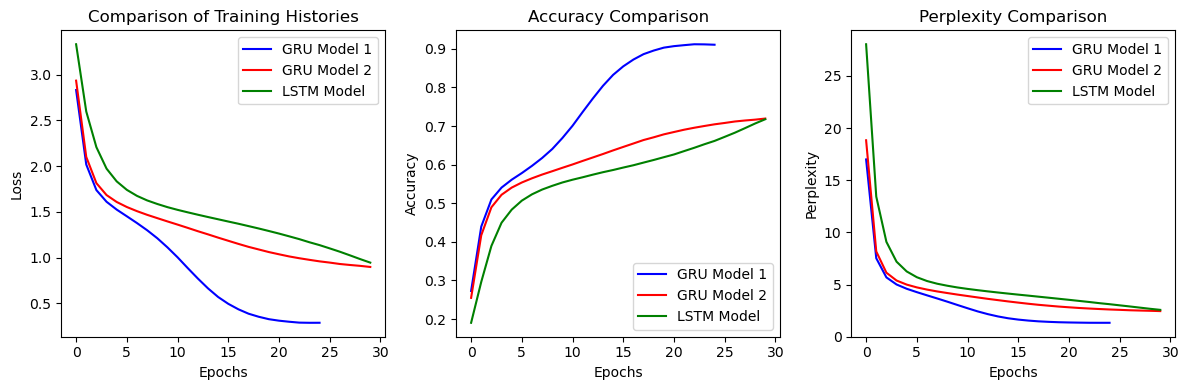

Loss:
 GRU Model 1: 0.2868843972682953
 GRU Model 2: 0.8973823189735413
 LSTM Model:  0.9448300004005432
Accuracy:
 GRU Model 1: 0.9104187488555908
 GRU Model 2: 0.719274640083313
 LSTM Model:  0.7175531983375549
Perplexity:
 GRU Model 1: 1.3322701904997185
 GRU Model 2: 2.4531730743246496
 LSTM Model:  2.5723760385193604
Training Times:
 GRU Model 1: 1148.437810s
 GRU Model 2: 947.854230s
 LSTM Model:  1273.380227s


In [116]:
loss1 = gru_model_1_history.history['loss']
loss2 = gru_model_2_history.history['loss']
loss3 = lstm_model_history.history['loss']

accuracy1 = gru_model_1_history.history['accuracy']
accuracy2 = gru_model_2_history.history['accuracy']
accuracy3 = lstm_model_history.history['accuracy']

perplexity1 = np.exp(loss1)
perplexity2 = np.exp(loss2)
perplexity3 = np.exp(loss3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4)) 

axes[0].plot(loss1, label="GRU Model 1", linestyle='-', color='blue')
axes[0].plot(loss2, label="GRU Model 2", linestyle='-', color='red')
axes[0].plot(loss3, label="LSTM Model", linestyle='-', color='green')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_title("Comparison of Training Histories")
axes[0].legend()

axes[1].plot(accuracy1, label="GRU Model 1", linestyle='-', color='blue')
axes[1].plot(accuracy2, label="GRU Model 2", linestyle='-', color='red')
axes[1].plot(accuracy3, label="LSTM Model", linestyle='-', color='green')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Comparison")
axes[1].legend()

axes[2].plot(perplexity1, label="GRU Model 1", linestyle='-', color='blue')
axes[2].plot(perplexity2, label="GRU Model 2", linestyle='-', color='red')
axes[2].plot(perplexity3, label="LSTM Model", linestyle='-', color='green')
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Perplexity")
axes[2].set_title("Perplexity Comparison")
axes[2].legend()

plt.tight_layout()

plt.show()
print("Loss:")
print(f" GRU Model 1: {loss1[-1]}")
print(f" GRU Model 2: {loss2[-1]}")
print(f" LSTM Model:  {loss3[-1]}")
print("Accuracy:")
print(f" GRU Model 1: {accuracy1[-1]}")
print(f" GRU Model 2: {accuracy2[-1]}")
print(f" LSTM Model:  {accuracy3[-1]}")
print("Perplexity:")
print(f" GRU Model 1: {perplexity1[-1]}")
print(f" GRU Model 2: {perplexity2[-1]}")
print(f" LSTM Model:  {perplexity3[-1]}")
print("Training Times:")
print(f" GRU Model 1: {gru_model_1_training_time:2f}s")
print(f" GRU Model 2: {gru_model_2_training_time:2f}s")
print(f" LSTM Model:  {lstm_model_training_time:2f}s")